## Imports


In [1]:
import json
import os
import sys
from pathlib import Path
import pandas as pd
from requests import HTTPError

In [2]:
from mvg import MVG

In [3]:
#ENDPOINT = "https://api.beta.multiviz.com"
ENDPOINT = "http://127.0.0.1:8000"
# Replace by your own Token
VALID_TOKEN = os.environ['TEST_TOKEN']

In [4]:
session = MVG(ENDPOINT, VALID_TOKEN)

We now check if the server is alive.
The hello message contains the API version:

In [5]:
hello_message = json.dumps(session.say_hello())
hello_message


'{"api": {"name": "MultiViz Engine API", "version": "0.0.0-dev0", "swagger": "http://127.0.0.1:8000/docs"}}'

Checking MVG version

In [6]:
hello_message = json.dumps(session.check_version())
hello_message

Using developer API: 0.0.0-dev0. You must confirm compatibility yourself.


'{"api_version": "0.0.0-dev0", "mvg_highest_tested_version": "0.1.15", "mvg_version": "0.8.0"}'

## Sources and Measurements

Before we begin, we will ensure there are no previously existing sources and if there are, we will delete them.

In [7]:
sources = session.list_sources()

print("Retrieved sources")
for src in sources:
    print(src)
    print(f"Deleting {src['source_id']}")
    session.delete_source(src['source_id'])


Retrieved sources
{'source_id': 'u0001', 'meta': {'assetId': 'assetA', 'measPoint': 'mloc01', 'location': 'paris'}, 'properties': {'data_class': 'waveform'}}
Deleting u0001


In [8]:
# Path to the source folder
#REF_DB_PATH = Path.cwd() / "va-data-charlie" / "charlieDb" / "acc"
REF_DB_PATH = Path.cwd() / "test_data" / "mini_charlie"
REF_DB_PATH
# Definition of the source_id
SOURCE_ID = "u0001"
SOURCE_ID

'u0001'

In [9]:
# Create source
src_path = REF_DB_PATH / SOURCE_ID
meta_filename = src_path / "meta.json"
with open(meta_filename, "r") as json_file:
    meta = json.load(json_file)
session.create_source(SOURCE_ID, meta)
session.get_source(SOURCE_ID)

{'source_id': 'u0001',
 'meta': {'assetId': 'assetJ', 'measPoint': 'mloc01', 'location': 'cancun'},
 'properties': {'data_class': 'waveform'}}

List sources

In [10]:
sources = session.list_sources()
sources

[{'source_id': 'u0001',
  'meta': {'assetId': 'assetJ', 'measPoint': 'mloc01', 'location': 'cancun'},
  'properties': {'data_class': 'waveform'}}]

In [11]:
# meas is a list of timestamps representing the measurements in our repo
meas = {f.split(".")[0] for f in os.listdir(src_path)}
# We remove the "meta" file from this list
meas.remove("meta")


In [12]:
# We iterate over all of elements in this list
for m in meas:

    # raw data per measurement
    TS_MEAS = str(m) + ".csv"  # filename
    TS_MEAS = REF_DB_PATH / SOURCE_ID / TS_MEAS  # path to file
    ts_df = pd.read_csv(TS_MEAS, names=['acc'])  # read csv into df
    accs = ts_df.iloc[:, 0].tolist()  # convert to list
    print(f"Read {len(accs)} samples")

    # meta information file per measurement
    TS_META = str(m) + ".json"  # filename
    TS_META = REF_DB_PATH / SOURCE_ID / TS_META  # path
    with open(TS_META, "r") as json_file:  # read json
        meas_info = json.load(json_file)  # into dict
    print(f"Read meta:{meas_info}")

    # get duration and other meta info
    duration = meas_info['duration']
    meta_info = meas_info['meta']

    # Upload measurements
    print(f"Uploading {TS_MEAS}")
    try:
        session.create_measurement(sid=SOURCE_ID,
                                   duration=duration,
                                   timestamp=m,
                                   data=accs,
                                   meta=meta_info)
    except HTTPError as exc:
        print(exc)


Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading C:\Users\Sergio\Documents\GitHub\mvg\docs\source\content\examples\test_data\mini_charlie\u0001\1573214460.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading C:\Users\Sergio\Documents\GitHub\mvg\docs\source\content\examples\test_data\mini_charlie\u0001\1574337660.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading C:\Users\Sergio\Documents\GitHub\mvg\docs\source\content\examples\test_data\mini_charlie\u0001\1571828460.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading C:\Users\Sergio\Documents\GitHub\mvg\docs\source\content\examples\test_data\mini_charlie\u0001\1573646460.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading C:\Users\Sergio\Documents\GitHub\mvg\docs\source\content\examples\test_data\mini_charlie\u0001\1573300860.csv
Read 40000 samples
Read meta:{

Check if we actually created the measurements by reading them.

In [13]:
m = session.list_measurements(SOURCE_ID)
print(f"Read {len(m)} stored measurements")


Read 47 stored measurements


## Analysis

We begin by listing all the features available in the service.

In [14]:
available_features = session.supported_features()
available_features


{'RMS': '1.0.0', 'ModeId': '0.1.1', 'BlackSheep': '1.0.0', 'KPIDemo': '1.0.0'}

### KPIDemo

Request KPIDemo analysis

In [15]:
KPI_u0001 = session.request_analysis(SOURCE_ID, 'KPIDemo')
KPI_u0001

{'request_id': '45f202227d51402eb7e71efd58370415', 'request_status': 'queued'}

In [16]:
REQUEST_ID_KPI_u0001 = KPI_u0001['request_id']
status = session.get_analysis_status(REQUEST_ID_KPI_u0001)
print(f"KPIDemo Analysis: {status}")


KPIDemo Analysis: successful


In [17]:
kpi_results = session.get_analysis_results(request_id=REQUEST_ID_KPI_u0001)

kpi_results.keys()


dict_keys(['status', 'request_id', 'feature', 'results', 'inputs', 'error_info', 'debug_info'])

### Visualization

In [19]:
from mvg import analysis_classes

In [33]:
#kpi_results_parsed = analysis_classes.parse_results(kpi_results)
kpi_results_parsed = analysis_classes.parse_results(kpi_results, t_zone="Europe/Stockholm", t_unit="s")

From here, we can call these results into a Pandas dataframe.

In [34]:
df_rms = kpi_results_parsed.to_df()
df_rms.head()


,rms,peak,peak2peak,variance,crest_factor,utilization,dc_component,timestamps,datetime
0,0.484976,2.260088,4.586670,0.235202,4.797310,1,-0.114825,1570186860,2019-10-04 13:01:00+02:00
1,0.485104,2.287657,4.593750,0.235326,4.753810,1,-0.114500,1570273260,2019-10-05 13:01:00+02:00
2,0.485239,2.243377,4.527527,0.235457,4.707268,1,-0.115203,1570359660,2019-10-06 13:01:00+02:00
3,0.485225,2.332046,4.654236,0.235444,4.806110,1,-0.114761,1570446060,2019-10-07 13:01:00+02:00
4,0.485088,2.285862,4.603882,0.235310,4.778556,1,-0.114598,1570532460,2019-10-08 13:01:00+02:00


In [22]:
kpi_results_parsed.summary()


=== KPIDemo ===
request_id 45f202227d51402eb7e71efd58370415
from 1570186860 to 1574424060

+-------+------------+-----------+-------------+-------------+----------------+---------------+----------------+--------------+
|       |        rms |      peak |   peak2peak |    variance |   crest_factor |   utilization |   dc_component |   timestamps |
|-------+------------+-----------+-------------+-------------+----------------+---------------+----------------+--------------|
| count | 47         | 47        |   47        | 47          |       47       |     47        |   47           | 47           |
| mean  |  0.253604  |  1.18052  |    2.3696   |  0.111436   |        4.52285 |      0.468085 |   -0.0536976   |  1.57235e+09 |
| std   |  0.219421  |  1.04772  |    2.10471  |  0.117385   |        0.31278 |      0.504375 |    0.0578918   |  1.29009e+06 |
| min   |  0.0496268 |  0.188155 |    0.38385  |  0.00246282 |        3.8463  |      0        |   -0.115203    |  1.57019e+09 |
| 25%   |  0.

,rms,peak,peak2peak,variance,crest_factor,utilization,dc_component,timestamps
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,4.700000e+01
mean,0.253604,1.180520,2.369598,0.111436,4.522848,0.468085,-0.053698,1.572347e+09
std,0.219421,1.047721,2.104707,0.117385,0.312780,0.504375,0.057892,1.290089e+06
min,0.049627,0.188155,0.383850,0.002463,3.846298,0.000000,-0.115203,1.570187e+09
25%,0.049950,0.207265,0.415436,0.002495,4.282076,0.000000,-0.114676,1.571180e+09
50%,0.050210,0.230495,0.451538,0.002521,4.707268,0.000000,-0.000433,1.572437e+09
75%,0.484982,2.282787,4.587006,0.235207,4.788712,1.000000,0.000031,1.573430e+09
max,0.485722,2.394923,4.682495,0.235926,4.980073,1.000000,0.000477,1.574424e+09


Finally, we can generate a plot that displays these results.

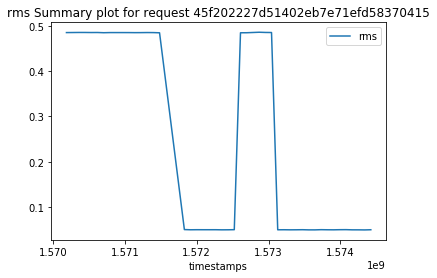

''

In [23]:
#["rms", "dc", "utilization"]
kpi_results_parsed.plot()

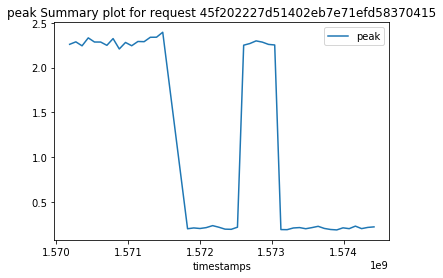

''

In [24]:
#["rms", "dc", "utilization"]
kpi_results_parsed.plot(kpi="peak")

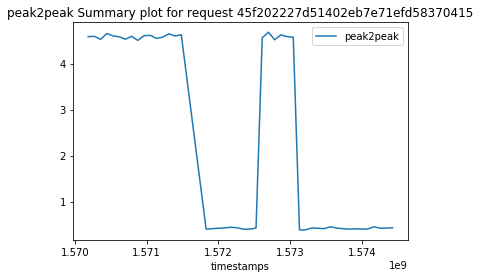

''

In [25]:
#["rms", "dc", "utilization"]
kpi_results_parsed.plot(kpi="peak2peak")

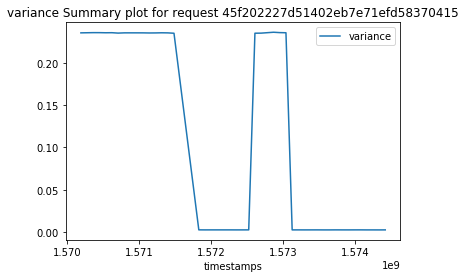

''

In [26]:
#["rms", "dc", "utilization"]
kpi_results_parsed.plot(kpi="variance")


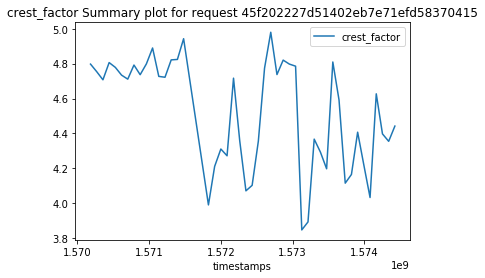

''

In [27]:
#["rms", "dc", "utilization"]
kpi_results_parsed.plot(kpi="crest_factor")

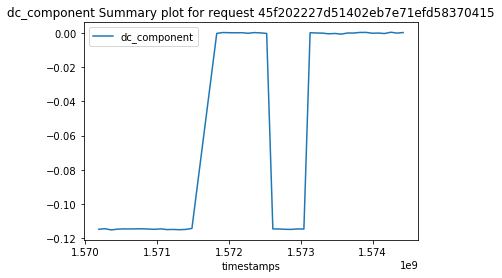

''

In [28]:
#["rms", "dc", "utilization"]
kpi_results_parsed.plot(kpi="dc_component")


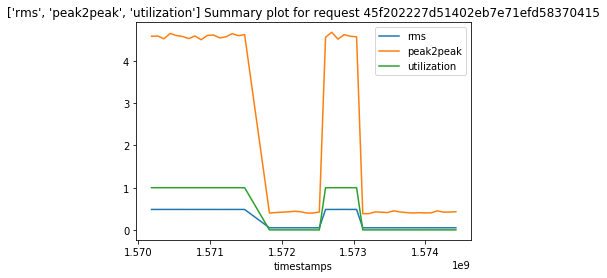

''

In [29]:
kpis = ["rms", "peak2peak", "utilization"]
kpi_results_parsed.plot(kpi=kpis)


In [30]:
import json

In [32]:
with open('KPIDemo_results_dict.json', 'w') as f:
    json.dump(kpi_results, f)
#jstr = json.dumps(kpi_results)